**Team Members: Ethan Wong, Timmy Ren, Mason Shu, Medha Nalamada, Carson Mullen, Bethel Kim**

*Note to all: Please pull any changes from the repo before working on this file!*

# Scraping from Edmunds.com

In [6]:
# Installing necessary libraries

# !pip install selenium
# !pip install google-colab-selenium
# !pip install nltk
# !pip install webdriver-manager

In [1]:
# Running necessary libraries

import pandas as pd
import nltk
from nltk.corpus import stopwords
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from collections import Counter
import re
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
from sklearn.manifold import MDS

In [2]:
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(sentences):
    filtered_sentences = []
    for sentence in sentences:
        words = sentence.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        filtered_sentence = ' '.join(filtered_words)
        filtered_sentences.append(filtered_sentence)

    return filtered_sentences

We decided to choose the newest posts for our analyses!

In [3]:
# Set up Selenium to use Chrome browser
chrome_options = Options()
chrome_options.add_argument("--headless")  # Run in headless mode (without opening a browser window)
chrome_service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

# Access the last page of the discussion
last_page = 435 
url = f'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{last_page}'
driver.get(url)

# Extract elements containing the messages and dates
elements = driver.find_elements("xpath", "//div[contains(@class,'Message') and contains(@class,'userContent')]")
elements2 = driver.find_elements("xpath", "//span[@class='MItem DateCreated']//time")

text = []
dates = []
unique_messages = set()  # Set to track unique messages

print(f"Scraping page {last_page}")
for element in elements:
    # Find blockquotes within the element and remove their text
    blockquote_elements = element.find_elements("xpath", ".//blockquote")
    message = element.text

    for blockquote in blockquote_elements:
        message = message.replace(blockquote.text, "")

    if message not in unique_messages:
        text.append(message.strip())
        unique_messages.add(message)

for element in elements2:
    dates.append(element.text)

# Loop through pages in reverse order
for i in range(last_page - 1, 0, -1):
    print(f"Scraping page {i}")
    url = f'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{i}'
    driver.get(url)

    elements = driver.find_elements("xpath", "//div[contains(@class,'Message') and contains(@class,'userContent')]")
    elements2 = driver.find_elements("xpath", "//span[@class='MItem DateCreated']//time")

    for element in elements:
        # Find blockquotes within the element and remove their text
        blockquote_elements = element.find_elements("xpath", ".//blockquote")
        message = element.text
        
        for blockquote in blockquote_elements:
            message = message.replace(blockquote.text, "")
        
        if message not in unique_messages:
            text.append(message.strip())
            unique_messages.add(message)
        if len(text) >= 5000:
            break  # Stop collecting once we have 5000 unique posts

    for element in elements2:
        dates.append(element.text)
        if len(text) >= 5000:
            break  # Stop collecting once we have 5000 unique posts

    if len(text) >= 5000:
        print(f"Collected 5000 unique posts, stopping at page {i+1}")
        break

    

# Close the browser
driver.quit()

# Ensure the lengths of text and dates are the same before saving
if len(text) > len(dates):
    text = text[:len(dates)]
elif len(dates) > len(text):
    dates = dates[:len(text)]

Scraping page 435
Scraping page 434
Scraping page 433
Scraping page 432
Scraping page 431
Scraping page 430
Scraping page 429
Scraping page 428
Scraping page 427
Scraping page 426
Scraping page 425
Scraping page 424
Scraping page 423
Scraping page 422
Scraping page 421
Scraping page 420
Scraping page 419
Scraping page 418
Scraping page 417
Scraping page 416
Scraping page 415
Scraping page 414
Scraping page 413
Scraping page 412
Scraping page 411
Scraping page 410
Scraping page 409
Scraping page 408
Scraping page 407
Scraping page 406
Scraping page 405
Scraping page 404
Scraping page 403
Scraping page 402
Scraping page 401
Scraping page 400
Scraping page 399
Scraping page 398
Scraping page 397
Scraping page 396
Scraping page 395
Scraping page 394
Scraping page 393
Scraping page 392
Scraping page 391
Scraping page 390
Scraping page 389
Scraping page 388
Scraping page 387
Scraping page 386
Scraping page 385
Scraping page 384
Scraping page 383
Scraping page 382
Scraping page 381
Scraping p

In [9]:
# Create a DataFrame and save it to a CSV file
df_original = pd.DataFrame({'Message': text, 'Date': dates})
#df_original.to_csv('ScrapedData.csv', index=False, encoding='utf-8') # Use this for task A!

# Remove stopwords and save the modified data
df = df_original.copy()
text = remove_stopwords(text)
df['Message'] = text
#df.to_csv('ScrapedDataMod.csv', index=False, encoding='utf-8') # Use this for task B onwards!

# Task A: Testing Zipf's law econometrically and plotting the most common 100 words in the data against the theoretical prediction of the law.

Note: Stopwords not removed, and stemming or lemmatization not performed.

In [11]:
# Load dataframes (to not scrape again)

df_original = pd.read_csv('ScrapedData.csv')
df = pd.read_csv('ScrapedDataMod.csv')

df_original['Message'] = df_original['Message'].apply(str)
df['Message'] = df['Message'].apply(str)

In [4]:
all_text = ' '.join(df_original['Message'].dropna())
words = re.findall(r'\w+', all_text.lower())
word_counts = Counter(words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [5]:
word_freq_df.head()

,Word,Frequency
11,the,24056
37,a,11590
108,i,11040
35,to,10064
0,and,9902


In [6]:
word_freq_df = word_freq_df.reset_index(drop=True)
word_freq_df['rank'] = word_freq_df.index + 1
wf_100 = word_freq_df[:100]

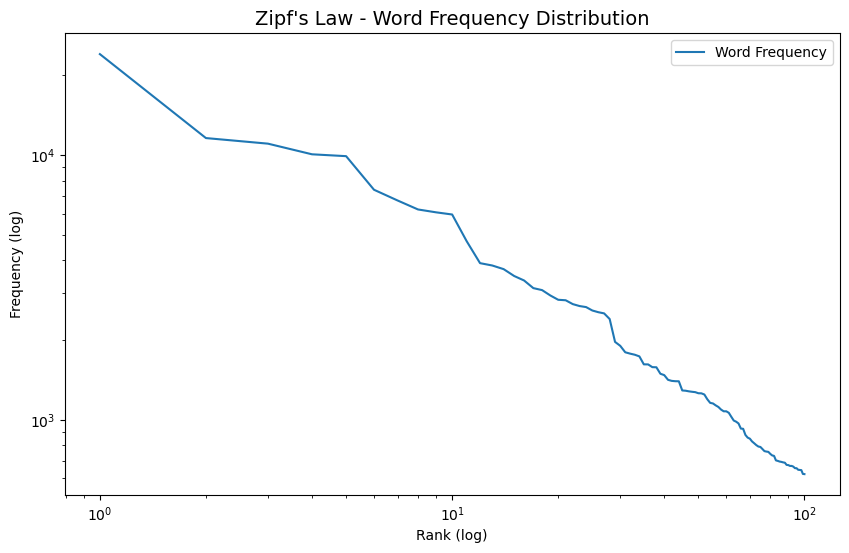

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(wf_100['rank'], wf_100['Frequency'], label='Word Frequency')

plt.xscale('log')
plt.yscale('log')

plt.title("Zipf's Law - Word Frequency Distribution", fontsize=14)
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")

plt.legend()
plt.show()

Slope: -0.8594102056651519
R-squared: 0.9847839090861142


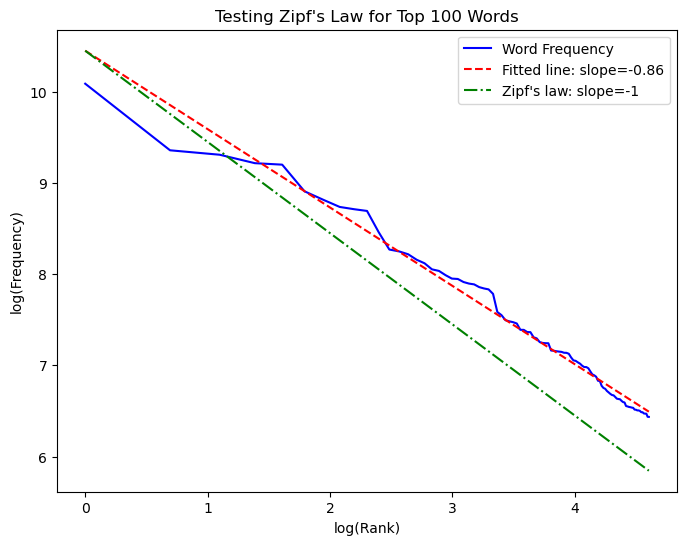

In [8]:
# Checking if Zipf's law is supported econometrically

log_rank = np.log(wf_100['rank'])
log_freq = np.log(wf_100['Frequency'])

# Linear Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(log_rank, log_freq)

print(f"Slope: {slope}")
print(f"R-squared: {r_value**2}") # squaring the R-value to get R-squared

# comparing the plots of the actual data vs. theoretical prediction of Zipf's law
#actual data
plt.figure(figsize=(8, 6))
plt.plot(log_rank, log_freq, color='blue', label='Word Frequency')

#Zipf's law
predicted_log_frequency = intercept + slope * log_rank
plt.plot(log_rank, predicted_log_frequency, 'r', ls = '--', label=f'Fitted line: slope={slope:.2f}')
expected_frequency = intercept - log_rank #equivalent to intercept + -1*log_rank
plt.plot(log_rank, expected_frequency, 'g', ls = '-.', label=f'Zipf\'s law: slope={-1}')

plt.xlabel('log(Rank)')
plt.ylabel('log(Frequency)')
plt.title("Testing Zipf's Law for Top 100 Words")
plt.legend()
plt.show()

# The slope is -0.85, which is close to the Zipf's law slope of -1

In [9]:
# Add a constant (intercept term) to the log_rank for OLS regression
log_rank_with_constant = sm.add_constant(log_rank)

# Fit the regression model
model = sm.OLS(log_freq, log_rank_with_constant)
results = model.fit()

# Print the summary
print(results.summary())

# Extracting the slope (beta coefficient) using label
slope = results.params['rank']

# Hypothesis test: H0: beta = -1
# Calculate t-statistic for testing beta = -1
t_statistic = (slope + 1) / results.bse['rank']

# Calculate the p-value for a two-tailed test
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), df=results.df_resid))

print(f"t-statistic: {t_statistic}")
print(f"p-value for testing if slope is -1: {p_value}")

                            OLS Regression Results                            
Dep. Variable:              Frequency   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     6343.
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           6.94e-91
Time:                        00:42:22   Log-Likelihood:                 89.730
No. Observations:                 100   AIC:                            -175.5
Df Residuals:                      98   BIC:                            -170.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4497      0.040    258.038      0.0

The 95% CI of the slope is (-0.881, -0.838). While -0.8594 is quite close to -1, we are at least 95% confident that the true beta value is not -1 and we can safely reject the null hypothesis. 

To further test this, we created a t-test to evaluate if the slope of the log-log regression could actually be equal to -1. Since the t-statistc is 13.02 we again can safely reject the null hypothesis that beta = -1. 

According to our calculations, the frequency is not exactly inversely proportional to the rank in the frequency table.

# Task B: Finding the top 10 brands from frequency counts.

Note: Stopwords not counted, and analysis is performed at the brand level.

In [66]:
# Load car models and brands data
df2 = pd.read_csv("car_models_and_brands.csv")

# Removing non-car brands from data
to_drop = ['car', 'seat', 'problem', 'sedan']
df2 = df2[~df2['Brand'].isin(to_drop)]

car_brands = df2['Brand'].str.lower().unique()
model_to_brand = dict(zip(df2['Model'].str.lower(), df2['Brand'].str.lower()))
results = []

# Extract car brands from posts
for index, row in df.iterrows():
    message = row['Message']
    message = re.sub(r'\W+', ' ', message.lower())  # Clean the message by removing punctuation and converting to lowercase
    words = message.split()
    
    # Perform exact word matching
    found_brands = set([brand for brand in car_brands if brand in words])
    found_models = [model for model in model_to_brand if model in words]
    found_brands.update([model_to_brand[model] for model in found_models])

    results.append(', '.join(found_brands))

df['Brands'] = results

# Continue with your existing code to count frequencies
df_exploded = df['Brands'].str.split(',').explode().str.strip()
df_exploded = df_exploded[df_exploded != '']

brand_counts = df_exploded.value_counts()
top_10_brands = brand_counts.head(10)
print(top_10_brands)

Brands
bmw           1024
audi           835
acura          529
honda          433
volkswagen     243
infiniti       238
cadillac       218
toyota         204
mercedes       198
hyundai        190
Name: count, dtype: int64


# Task C: Calculating the lift ratios for associations between the top 10 brands identified in Task A.

Note: Counting of a brand is done once per post, and a message is not counted in the lift calculations if the mentions of the two brands are separated by approximately 5-7 words.

In [11]:
top_10_brands_list = top_10_brands.index.str.lower().tolist()

# Function to clean and tokenize text (removes punctuation)
def clean_text(text):
    text = re.sub(r'\W+', ' ', text.lower())  # Remove punctuation and convert to lowercase
    words = text.split()
    return words  

def find_brand_pairs(message, brands, window=5):
    message = re.sub(r'\W+', ' ', message.lower())  # Clean the message
    words = message.split()
    brand_indices = {brand: [] for brand in brands}

    # Track the position of each brand in the message
    for i, word in enumerate(words):
        if word in brands:
            brand_indices[word].append(i)

    # Find pairs within the given window
    brand_pairs = set()
    brands_list = list(brand_indices.keys())
    for idx1, brand1 in enumerate(brands_list):
        indices1 = brand_indices[brand1]
        for idx2 in range(idx1 + 1, len(brands_list)):
            brand2 = brands_list[idx2]
            indices2 = brand_indices[brand2]
            for i1 in indices1:
                for i2 in indices2:
                    if abs(i1 - i2) - 1 <= window:
                        pair = tuple(sorted((brand1, brand2)))
                        brand_pairs.add(pair)
    return brand_pairs

# Function to calculate word frequencies and word pair co-occurrences
def calculate_frequencies(df, top_brands, window=5):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(int)

    # Loop through each post and count word occurrences
    for index, row in df.iterrows():
        message = row['Message']
        words_in_message = set(clean_text(message))
        brands_in_message = words_in_message.intersection(top_brands)
        
        # Include models mapped to brands, but only if the brand is in the top 10
        models_in_message = words_in_message.intersection(set(model_to_brand.keys()))
        mapped_brands = [model_to_brand[model] for model in models_in_message]
        mapped_brands = [brand for brand in mapped_brands if brand in top_brands]
        brands_in_message.update(mapped_brands)

        # Update word frequencies
        for brand in brands_in_message:
            word_frequency[brand] += 1

        # Update pair frequencies
        brand_pairs = find_brand_pairs(message, top_brands, window=window)
        for brand_pair in brand_pairs:
            if brand_pair[0] in brands_in_message and brand_pair[1] in brands_in_message:
                word_pair_frequency[brand_pair] += 1

    return word_frequency, word_pair_frequency


# Function to calculate lift
def calculate_lift(word_frequency, word_pair_frequency, total_posts):
    lift_values = []

    for (brand1, brand2), pair_count in word_pair_frequency.items():
        p_brand1 = word_frequency[brand1] / total_posts
        p_brand2 = word_frequency[brand2] / total_posts
        p_both = pair_count / total_posts

        if p_brand1 * p_brand2 > 0:
            lift = p_both / (p_brand1 * p_brand2)
            lift_values.append({
                'Brand 1': brand1,
                'Brand 2': brand2,
                'Lift': lift
            })

    return pd.DataFrame(lift_values)

# Main function to process data and compute lift ratios
def main(df, top_10_brands_list, window=7):
    # Step 1: Calculate word and word pair frequencies
    total_posts = len(df)
    word_frequency, word_pair_frequency = calculate_frequencies(df, top_10_brands_list, window)
    
    # Step 2: Calculate lift values
    lift_df = calculate_lift(word_frequency, word_pair_frequency, total_posts)
    
    # Step 3: Create lift matrix
    lift_matrix = lift_df.pivot(index='Brand 1', columns='Brand 2', values='Lift')
    
    # Ensure all brands are present in both axes
    all_brands = sorted(set(top_10_brands_list))
    lift_matrix = lift_matrix.reindex(index=all_brands, columns=all_brands)
    
    # Replace missing values with 0
    lift_matrix = lift_matrix.fillna(0)
    
    # Convert DataFrame to object type to allow setting string values
    lift_matrix = lift_matrix.astype(object)
    
    # Set the diagonal and lower triangle to '-'
    for i in range(len(all_brands)):
        lift_matrix.iloc[i, i] = '-'  # Set diagonal to '-'
        for j in range(i):
            lift_matrix.iloc[i, j] = '-'  # Set lower triangle to '-'
    
    # Remove 'Brand 1' and 'Brand 2' labels from being displayed
    lift_matrix.index.name = None
    lift_matrix.columns.name = None
    
    # Return both lift_matrix and lift_df
    #return lift_matrix, lift_df
    return lift_matrix, lift_df, word_frequency, word_pair_frequency

# Execute the main function and capture the lift matrix and lift DataFrame
#lift_matrix, lift_df = main(df, top_10_brands_list, stop_words, window=7)
lift_matrix, lift_df, word_frequency, word_pair_frequency = main(df, top_10_brands_list, window=7)

# Display the lift matrix as a DataFrame
lift_matrix

,acura,audi,bmw,cadillac,honda,hyundai,infiniti,mercedes,toyota,volkswagen
acura,-,0.733414,0.561245,0.994017,1.283768,0.148761,2.375181,0.999255,0.323288,0.0
audi,-,-,1.066701,1.177344,0.179204,0.157075,1.128566,2.110204,0.175555,0.049126
bmw,-,-,-,0.937715,0.078684,0.179317,0.879366,2.040286,0.119294,0.02003
cadillac,-,-,-,-,0.1584,0.360985,1.536967,2.309332,0.560353,0.094084
honda,-,-,-,-,-,0.484648,0.193452,0.232533,1.015623,0.0
hyundai,-,-,-,-,-,-,0.220433,0.264965,0.514345,0.0
infiniti,-,-,-,-,-,-,-,1.903743,0.205306,0.0
mercedes,-,-,-,-,-,-,-,-,0.246782,0.103587
toyota,-,-,-,-,-,-,-,-,-,0.0
volkswagen,-,-,-,-,-,-,-,-,-,-


# Sanity Checks for Task B and C (remove later)

In [12]:
# Extract word frequencies from Task C
# Note: word_frequency is a defaultdict, convert it to a regular dict for comparison
word_frequency_c = dict(word_frequency)

# Extract brand counts from Task B
brand_counts_b = brand_counts.to_dict()

# Compare the frequencies for top 10 brands
print("Brand Frequencies from Task B vs Task C:")
for brand in top_10_brands_list:
    freq_b = brand_counts_b.get(brand, 0)
    freq_c = word_frequency_c.get(brand, 0)
    print(f"{brand.capitalize()}: Task B = {freq_b}, Task C = {freq_c}")

Brand Frequencies from Task B vs Task C:
Bmw: Task B = 1024, Task C = 1024
Audi: Task B = 835, Task C = 835
Acura: Task B = 529, Task C = 529
Honda: Task B = 433, Task C = 433
Volkswagen: Task B = 243, Task C = 243
Infiniti: Task B = 238, Task C = 238
Cadillac: Task B = 218, Task C = 218
Toyota: Task B = 204, Task C = 204
Mercedes: Task B = 198, Task C = 198
Hyundai: Task B = 190, Task C = 190


In [13]:
sample_messages = [
    "I love my new BMW, but I'm considering getting an Audi next time.",
    "The Honda Accord has been a reliable car for years.",
    "Just saw a Mercedes and an Infiniti racing down the highway.",
    "Looking at Toyota and Ford trucks for my next purchase.",
    "No car brand mentioned here."
]

for message in sample_messages:
    print(f"Message: {message}")
    # Apply the same preprocessing as in your code
    message_cleaned = re.sub(r'\W+', ' ', message.lower())
    words = message_cleaned.split()
    found_brands = set([brand for brand in car_brands if brand in words])
    found_models = [model for model in model_to_brand if model in words]
    found_brands.update([model_to_brand[model] for model in found_models])
    print(f"Brands Detected: {', '.join(found_brands)}\n")

Message: I love my new BMW, but I'm considering getting an Audi next time.
Brands Detected: audi, bmw

Message: The Honda Accord has been a reliable car for years.
Brands Detected: honda

Message: Just saw a Mercedes and an Infiniti racing down the highway.
Brands Detected: mercedes-benz, mercedes, infiniti

Message: Looking at Toyota and Ford trucks for my next purchase.
Brands Detected: toyota, ford

Message: No car brand mentioned here.
Brands Detected: 



In [14]:
# Manually define a small subset of messages
subset_messages = [
    "BMW and Audi are both great brands.",
    "I prefer Honda over Toyota.",
    "Ford and Chrysler have been competitors for years.",
    "Mercedes and BMW often compete in the luxury segment."
]

# Manually calculate expected co-occurrence counts
manual_pair_counts = defaultdict(int)

for message in subset_messages:
    # Apply the same preprocessing as in your code
    message_cleaned = re.sub(r'\W+', ' ', message.lower())
    words = message_cleaned.split()
    brands_in_message = set([brand for brand in top_10_brands_list if brand in words])
    
    # Find brand pairs within the window (assuming window size is large enough to include all brands in the message)
    for brand1 in brands_in_message:
        for brand2 in brands_in_message:
            if brand1 < brand2:
                manual_pair_counts[(brand1, brand2)] += 1

print("Manual Co-occurrence Counts:")
for pair, count in manual_pair_counts.items():
    print(f"{pair}: {count}")

# Compare with word_pair_frequency from Task C
print("\nCo-occurrence Counts from Task C:")
for pair, count in word_pair_frequency.items():
    if pair in manual_pair_counts:
        print(f"{pair}: Task C = {count}, Manual = {manual_pair_counts[pair]}")

Manual Co-occurrence Counts:
('audi', 'bmw'): 1
('honda', 'toyota'): 1
('bmw', 'mercedes'): 1

Co-occurrence Counts from Task C:
('bmw', 'mercedes'): Task C = 83, Manual = 1
('audi', 'bmw'): Task C = 183, Manual = 1
('honda', 'toyota'): Task C = 18, Manual = 1


The counts from Task C are higher because they are calculated over the entire dataset of 5,000 messages, whereas the manual counts are from a small subset of 4 messages.

The counts should differ because the sample sizes are vastly different. This discrepancy is normal and indicates that the code is correctly counting co-occurrences over the entire dataset.

In [15]:
# Ensure brand names in lift_df are lowercase
lift_df['Brand 1'] = lift_df['Brand 1'].str.lower()
lift_df['Brand 2'] = lift_df['Brand 2'].str.lower()

# Select a brand pair from lift_df
brand_pair = ('bmw', 'audi')

# Get frequencies
total_posts = len(df)
freq_brand1 = word_frequency[brand_pair[0]]
freq_brand2 = word_frequency[brand_pair[1]]

# Since word_pair_frequency keys are tuples in a specific order, check both possible orders
freq_pair = word_pair_frequency.get((brand_pair[0], brand_pair[1]), 0) + \
            word_pair_frequency.get((brand_pair[1], brand_pair[0]), 0)

# Calculate probabilities
p_brand1 = freq_brand1 / total_posts
p_brand2 = freq_brand2 / total_posts
p_both = freq_pair / total_posts

# Calculate lift manually
lift_manual = p_both / (p_brand1 * p_brand2) if p_brand1 * p_brand2 > 0 else 0

# Get lift from lift_df
lift_row = lift_df[((lift_df['Brand 1'] == brand_pair[0]) & (lift_df['Brand 2'] == brand_pair[1])) |
                   ((lift_df['Brand 1'] == brand_pair[1]) & (lift_df['Brand 2'] == brand_pair[0]))]

if not lift_row.empty:
    lift_from_df = lift_row['Lift'].values[0]
    print(f"Manual Lift for {brand_pair}: {lift_manual}")
    print(f"Lift from lift_df: {lift_from_df}")
else:
    print(f"Lift value for {brand_pair} not found in lift_df.")

Manual Lift for ('bmw', 'audi'): 1.0667009730538923
Lift from lift_df: 1.0667009730538923


In [16]:
print("\nLift Values:")
print(lift_df.sort_values(by='Lift', ascending=False))


Lift Values:
     Brand 1     Brand 2      Lift
8      acura    infiniti  2.375181
5   cadillac    mercedes  2.309332
20      audi    mercedes  2.110204
3        bmw    mercedes  2.040286
1   infiniti    mercedes  1.903743
2   cadillac    infiniti  1.536967
6      acura       honda  1.283768
14      audi    cadillac  1.177344
7       audi    infiniti  1.128566
9       audi         bmw  1.066701
22     honda      toyota  1.015623
19     acura    mercedes  0.999255
15     acura    cadillac  0.994017
11       bmw    cadillac  0.937715
0        bmw    infiniti  0.879366
17     acura        audi  0.733414
10     acura         bmw  0.561245
30  cadillac      toyota  0.560353
35   hyundai      toyota  0.514345
21     honda     hyundai  0.484648
23  cadillac     hyundai  0.360985
24     acura      toyota  0.323288
39   hyundai    mercedes  0.264965
36  mercedes      toyota  0.246782
13     honda    mercedes  0.232533
28   hyundai    infiniti  0.220433
37  infiniti      toyota  0.205306
12    

In [17]:
print(f"Total Posts (from Task C): {total_posts}")
print(f"Total Posts (from DataFrame): {df.shape[0]}")

Total Posts (from Task C): 4984
Total Posts (from DataFrame): 4984


# Task D: Plotting the brands on a multi-dimensional scaling (MDS) map.

In [18]:
# Ensure brand names in lift_df are lowercase (if not already)
lift_df['Brand 1'] = lift_df['Brand 1'].str.lower()
lift_df['Brand 2'] = lift_df['Brand 2'].str.lower()

# Define the top 10 brands list (ensure it's lowercase)
top_10_brands_list = [brand.lower() for brand in top_10_brands_list]

# Filter lift_df to include only top 10 brands
lift_df = lift_df[
    (lift_df['Brand 1'].isin(top_10_brands_list)) &
    (lift_df['Brand 2'].isin(top_10_brands_list))
]

# List of brands (top 10 only)
brands = sorted(top_10_brands_list)

# Initialize the dissimilarity matrix with zeros
dissimilarity_matrix = pd.DataFrame(
    data=np.zeros((len(brands), len(brands))),
    index=brands,
    columns=brands
)

# Small epsilon to avoid division by zero
epsilon = 1e-5

# Fill the dissimilarity matrix
for index, row in lift_df.iterrows():
    brand1 = row['Brand 1']
    brand2 = row['Brand 2']
    lift = row['Lift']
    
    # Compute dissimilarity
    dissimilarity = 1 / (lift + epsilon)
    
    # Assign to the matrix
    dissimilarity_matrix.loc[brand1, brand2] = dissimilarity
    dissimilarity_matrix.loc[brand2, brand1] = dissimilarity  # Symmetric matrix

# Since the diagonal represents the dissimilarity of a brand with itself, set it to zero
np.fill_diagonal(dissimilarity_matrix.values, 0)

In [19]:
# Replace missing values (still zero after filling known dissimilarities) with a large dissimilarity
max_dissimilarity = dissimilarity_matrix.values.max()
dissimilarity_matrix = dissimilarity_matrix.replace(0, max_dissimilarity + 1)
np.fill_diagonal(dissimilarity_matrix.values, 0)  # Set the diagonal back to zero

In [20]:
# Convert the dissimilarity matrix to a NumPy array
dissimilarity_array = dissimilarity_matrix.values

# Create an MDS object
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')

# Fit the MDS model
mds_coordinates = mds.fit_transform(dissimilarity_array)

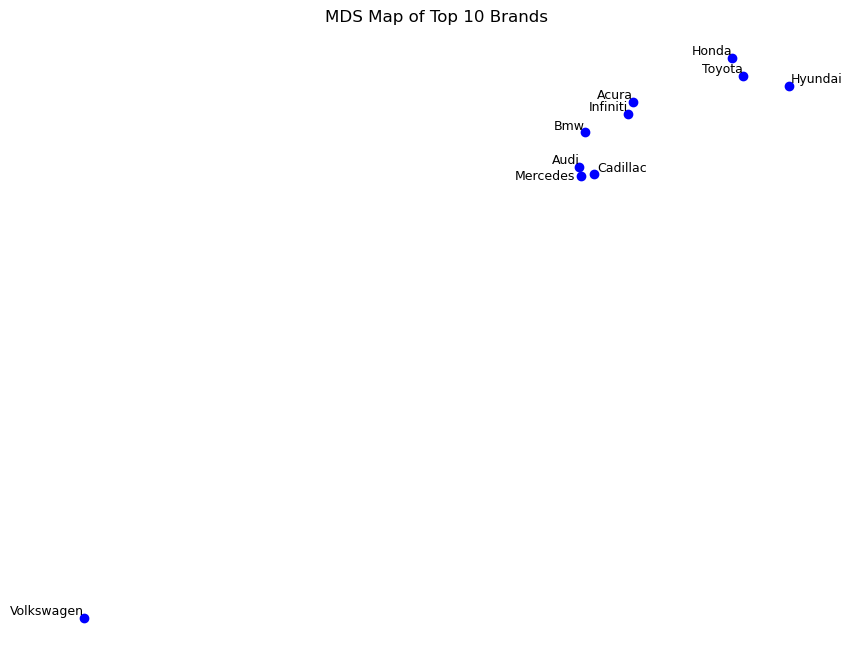

In [21]:
# Create a DataFrame with the coordinates
mds_df = pd.DataFrame(
    mds_coordinates,
    index=brands,
    columns=['Dimension 1', 'Dimension 2']
)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(mds_df['Dimension 1'], mds_df['Dimension 2'], color='blue')

# Annotate points with brand names
for brand, x, y in zip(mds_df.index, mds_df['Dimension 1'], mds_df['Dimension 2']):
    if brand == 'cadillac':
        x_offset = 1.3
        plt.text(x + x_offset, y, brand.capitalize(), fontsize=9, ha='right', va='bottom')
    elif brand == 'mercedes':
        x_offset = -0.15
        y_offset = -0.5
        plt.text(x + x_offset, y + y_offset, brand.capitalize(), fontsize=9, ha='right', va='bottom')
    elif brand == 'hyundai':
        x_offset = 1.3
        plt.text(x + x_offset, y, brand.capitalize(), fontsize=9, ha='right', va='bottom')
    else:
        plt.text(x, y, brand.capitalize(), fontsize=9, ha='right', va='bottom')

plt.title('MDS Map of Top 10 Brands')

# Remove axis labels
plt.xlabel('')
plt.ylabel('')

# Remove axis numbers (ticks)
plt.xticks([])
plt.yticks([])

# Remove the axes spines
plt.axis('off')

plt.show()

# Task E: Insights from Tasks C and D.

## Task C Insights (Lift Ratios for Brand Associations):

Infiniti’s Strong Connection with Acura:

The association between Acura and Infiniti shows the highest lift (2.37), which indicates that these brands are often discussed together. This could imply that Acura and Infiniti are perceived as direct competitors in the luxury car market. Additionally, Acura's other higher associations, such as with Cadillac (0.99) and Honda (1.28), highlight its presence across both luxury and near-luxury markets.

Mercedes's Significant Comparisons: 

Mercedes has consistently strong associations with other luxury brands such as Audi, BMW, Cadillac, and Infiniti. The high lift values, especially between Mercedes and Audi (2.11), BMW (2.04), and Cadillac (2.31), reveal that these brands are often mentioned together on the Edmunds.com post. This  suggests that Mercedes is frequently mentioned along with other luxury brands, reflecting its strong presence among consumers shopping for high-end cars.

BMW’s Significant Comparisons:

BMW shows significant associations with Mercedes (2.04) and Cadillac (0.94). This suggests that consumers frequently compare BMW with other premium brands and vehicles. Conversely, BMW has a relatively weak associations with non-luxury brands, such as Honda and Toyota, which may indicate that its market positioning is firmly in the luxury segment.

Audi's Significant Comparisons:

Audi has strong associations with Mercedes (2.11) and Cadillac (1.18), indicating that it is also seen as a key competitor in the luxury market. However, its lift values with non-luxury brands (such as Toyota and Honda) are significantly lower, suggesting that Audi's market focus is predominantly among luxury brands, similar to BMW.

## Task D Insights (Multi-dimensional Scaling Map):

Luxury Brands: Acura, BMW, Audi, Infiniti, Mercedes, and Cadillac are relatively close to each other in the MDS map, indicating that they are frequently perceived as competitors in the entry level luxury market. This suggests that consumers often compare these brands when making purchasing decisions, which aligns with their competitive positioning.


Non-Luxury Brands: Honda, Toyota, and Hyundai are positioned a bit farther from the core luxury brands. This suggests that these brands, while occasionally mentioned in the same context as luxury brands, are not seen as direct competitors in the same market. However, their positioning could indicate that they are sometimes viewed as alternatives for consumers newly entering the luxury market.

Volkswagen as a Clear Outlier: Volkswagen is positioned significantly apart from the other brands, suggesting that it is not frequently considered in direct comparison with the core luxury brands or the non-luxury brands. This could imply that it's seen as neither a direct competitor in the premium/luxury market nor a strong alternative in the non-luxury segment.

## Overall Advice 

Since brands like Acura, BMW, Audi, Infiniti, Mercedes, and Cadillac can be seen as closely categorized as competitors, it could be advantageous for these individual brands to focus on differentiating themselves in aspects beyond the luxury element. By emphasizing a focus on new in-car technology, driving performance, or other specific features, these established, entry-level luxury brands can highlight their unique strengths to consumers and promote brand loyalty. 

Non-luxury brands like Honda, Toyota, and Hyundai can be more successful in the entry-level business by focusing on customers who are making the transition from mainstream to luxury. For instance, promoting premium features and sub-brands (e.g. Toyota's Lexus and Hyundai's Genesis) as "beginner luxury" alternatives can help establish Toyota and Hyundai as brands that are more associated with luxury. The focus on accessibility within luxury will not only appeal to entry-level luxury consumers but will attract customers who may not even be considering the higher-end automobile lifestyle. 

Similarly, since Volkswagen seems to lack a competitive presence in the luxury market, their brand can also position itself as an affordable premium option. By maintaining focus on value-conscious customers who are looking for high quality without the luxury price tag, Volkswagen can gain a more competitive edge in the luxury market. Promoting its European engineering and specific upscale models may also help in upgrading Volkswagen's customer perception in American audiences. 

# Task F: Identifying the top 5 most frequently mentioned attributes or features of cars in the discussions and which attributes are strongly associated with which of the 5 brands.

In [95]:
#defining attributes to look for and seeing frequency within word_freq_df
car_attributes = ['performance', 'comfort', 'safety', 'reliability', 'design', 'price', 'features', 'handling', 'speed']
attribute_freq = word_freq_df[word_freq_df['Word'].isin(car_attributes)]
top_attributes = attribute_freq.sort_values(by='Frequency', ascending=False)
top_5_attributes = top_attributes.head(5)['Word']
top_5_attributes_list = top_5_attributes.str.lower().tolist()

In [96]:
#function to find pairs of attributes and brands within a messgae
def find_brand_attribute_pairs(message, brands, attributes, window=5):
    message = re.sub(r'\W+', ' ', message.lower())  # Clean the message
    words = message.split()
    brand_indices = {brand: [] for brand in brands}
    attr_indices = {attr: [] for attr in attributes}

    # track the position of each brand and attribute in the message
    for i, word in enumerate(words):
        if word in brands:
            brand_indices[word].append(i)
        if word in attributes:
            attr_indices[word].append(i)

    # find pairs within the given window
    brand_attribute_pairs = set()
    for brand in brands:
        for attr in attributes:
            indices_brand = brand_indices[brand]
            indices_attr = attr_indices[attr]
            for i1 in indices_brand:
                for i2 in indices_attr:
                    if abs(i1 - i2) - 1 <= window:
                        pair = (brand, attr)
                        brand_attribute_pairs.add(pair)
    return brand_attribute_pairs

# function to calculate frequencies and brand_attribute_pair occurences
def calculate_brand_attribute_frequencies(df, top_brands, top_attributes, window=5):
    brand_frequency = defaultdict(int)
    attribute_frequency = defaultdict(int)
    brand_attribute_frequency = defaultdict(int)

    # loop through each post and count brand-attribute occurrences
    for index, row in df.iterrows():
        message = row['Message']
        words_in_message = set(clean_text(message))
        brands_in_message = words_in_message.intersection(top_brands)
        attributes_in_message = words_in_message.intersection(top_attributes)

        # update frequencies
        for brand in brands_in_message:
            brand_frequency[brand] += 1

        for attribute in attributes_in_message:
            attribute_frequency[attribute] += 1

        brand_attribute_pairs = find_brand_attribute_pairs(message, top_brands, top_attributes, window=window)
        for brand, attribute in brand_attribute_pairs:
            brand_attribute_frequency[(brand, attribute)] += 1

    return brand_frequency, attribute_frequency, brand_attribute_frequency


# calculating lift values to find associations between attributes and brands
def calculate_brand_attribute_lift(brand_frequency, attribute_frequency, brand_attribute_frequency, total_posts):
    lift_values = []

    for (brand, attribute), pair_count in brand_attribute_frequency.items():
        p_brand = brand_frequency[brand] / total_posts
        p_attribute = attribute_frequency[attribute] / total_posts
        p_both = pair_count / total_posts

        if p_brand * p_attribute > 0:
            lift = p_both / (p_brand * p_attribute)
            lift_values.append({
                'Brands': brand,
                'Attribute': attribute,
                'Lift': lift
            })

    return pd.DataFrame(lift_values)

def main(df, top_brands, top_attributes, window=7):
    
    # finding pairs
    total_posts = len(df)
    brand_frequency, attribute_frequency, brand_attribute_frequency = calculate_brand_attribute_frequencies(df, top_brands, top_attributes, window)
    
    # caculating lift values
    lift_df = calculate_brand_attribute_lift(brand_frequency, attribute_frequency, brand_attribute_frequency, total_posts)
    lift_matrix = lift_df.pivot(index='Brands', columns='Attribute', values='Lift')
    
    # Ensure all brands and attributes are present in both axes
    all_brands = sorted(set(top_brands))
    all_attributes = sorted(set(top_attributes))
    lift_matrix = lift_matrix.reindex(index=all_brands, columns=all_attributes)
    
    # Replace missing values with 0
    lift_matrix = lift_matrix.fillna(0)
    
    return lift_matrix, lift_df, brand_frequency, attribute_frequency

#results
lift_matrix, lift_df, brand_frequency, attribute_frequency = main(df, top_brands_list, top_5_attributes_list, window=7)
print(lift_matrix)

Attribute   handling  performance     price  reliability     speed
Brands                                                            
acura       0.181603     0.494041  0.485510     1.270339  0.348146
audi        0.414184     0.420990  0.456985     0.602032  0.642780
bmw         0.767234     0.453333  0.589881     0.287001  0.317241
cadillac    0.000000     0.304753  0.594820     0.463046  0.000000
honda       0.469701     0.294876  0.279052     1.194774  0.150075
hyundai     0.475573     0.000000  0.141270     0.000000  0.000000
infiniti    0.000000     0.185155  0.000000     0.843983  0.282700
mercedes    0.225123     0.471104  0.668733     0.286322  0.575437
toyota      0.494101     0.000000  0.293548     2.513680  0.000000
volkswagen  0.000000     0.000000  1.130159     0.000000  0.000000


# Task G: Advice for Client based on Task F.

# Task H: Identifying the most aspirational brand in the data in terms of people wanting to actually buy or own.

In [13]:
# Describe analyses
    # Describe how we measured "aspirational" and how we found the most aspirational brand. 
# Describe business implications for this brand


In [90]:
# List of aspirational phrases
aspirational_phrases = [
    "aspire to", "would love", "next car", "next purchase", "goal", 
    "wish list", "would buy", "one day", "always wanted", "obsessed", 
    "gift", "ideal", "need need", "really want", "begging for", 
    "must have", "yearning for", "eye on", "top choice", "someday", 
    "desire", "crave", "pursue", "striving for", "dream", "longing for", 
    "seek", "covet"
]

In [92]:
def check_for_aspirational_phrases(phrases_list, df=df_original):
    # Create a regex pattern by joining the phrases with '|' (or) to search for all these phrases at once
    # re.escape(phrase) ensures that any special characters in the phrases are treated literally instead of part of the regex
    pattern = '|'.join([re.escape(phrase) for phrase in phrases_list])
    
    # Search for any of the phrases, ignoring case
    results = df[df['Message'].str.contains(pattern, case=False, na=False, regex=True)]

    print(len(results), "results")
    print()

    for i in results['Message']:
        print("NEW POST:")
        print()
        print(i)
        print()

check_for_aspirational_phrases(aspirational_phrases)

252 results

NEW POST:

It just made my next car list. Looks very much like A5 Sportsback. Wonder if the 4motion AWD is exactly the same tech as Audi’s quattro, or is it different. That’s often really hard to find out, unless you browse all those Audi/VW geek sites and even there you need to be careful who to believe.

Even if the package isn’t quite Audi, it looks like it will be 10 grand less, give or take for like configurations, especially in upper trim (mid 40s vs mid 50s), which seems a fair tradeoff if it delivers on essentials. VW has now 6-year btb warranty, probably to win trust back after the scandals, this definitely helps, as long as they make good on it.

NEW POST:

My local dealers have several of $39.5K-40.5K A4s in their stock (within 50 miles), so it is possible to get one if you really want it (I wouldn't). In upscale German brands equipment levels is mostly a decision of a local dealer's inventory manager (within model allotments) and their view of the market. I've 

In [110]:
# Extract the list of all brands
all_brands = list(brand_counts.keys())

def check_for_aspirational_phrases_all_brands(phrases_list, brand_list, df=df_original):
    # Create a regex pattern by joining the phrases with '|' (or) to search for all these phrases at once
    # re.escape(phrase) ensures that any special characters in the phrases are treated literally instead of part of the regex
    pattern = '|'.join([re.escape(phrase) for phrase in phrases_list])
    
    # Search for any of the phrases in the message, ignoring case
    results = df[df['Message'].str.contains(pattern, case=False, na=False, regex=True)]
    
    # Initialize a dictionary to store the count of aspirational mentions per brand
    brand_aspirational_counts = {brand: 0 for brand in brand_list}
    
    # Check each aspirational post for brand mentions
    for message in results['Message']:
        for brand in brand_list:
            if re.search(r'\b' + re.escape(brand) + r'\b', message, re.IGNORECASE):
                brand_aspirational_counts[brand] += 1

    print("Aspirational brand counts:")
    for brand, count in brand_aspirational_counts.items():
        print(f"{brand.capitalize()}: {count}")

    # To sum all the values in brand_aspirational_counts
    total_aspirational_mentions = sum(brand_aspirational_counts.values())

    print(f"Total aspirational mentions across all brands: {total_aspirational_mentions}")

    
    return brand_aspirational_counts

# Run the function using all the brands found in your data
aspirational_brand_counts_all = check_for_aspirational_phrases_all_brands(aspirational_phrases, all_brands)

Aspirational brand counts:
Bmw: 90
Audi: 71
Acura: 28
Honda: 14
Volkswagen: 0
Infiniti: 14
Cadillac: 22
Toyota: 10
Mercedes: 30
Hyundai: 8
Mercedes-benz: 1
Ford: 10
Volvo: 9
Kia: 9
Chevrolet: 0
Subaru: 5
Mazda: 10
Buick: 5
Dodge: 2
Lincoln: 8
Chrysler: 10
Nissan: 6
Volkwagen: 0
Pontiac: 1
Kia.: 0
Mercury: 2
Suzuki: 0
Saturn: 0
Mitsubishi: 1
Total aspirational mentions across all brands: 366
